Import

In [551]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [552]:
# Charger le dataset
df_base = pd.read_csv('data.csv', sep=';')
pd.set_option('display.max_columns', None) 
df = df_base.drop_duplicates()
df.columns = df.columns.str.lower()

In [553]:
df_base

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


Dataviz pré traitement

In [554]:
# # Distribution des valeurs
# cols = df_base.drop(columns='Dt_Customer').columns

# # Définir le nombre de lignes et de colonnes pour les subplots
# n_cols = 3
# n_rows = len(cols) // n_cols + (len(cols) % n_cols > 0)  # Arrondi vers le haut si besoin
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))

# # Aplatir les axes pour faciliter l'itération
# axes = axes.flatten()

# # Boucle à travers les colonnes pour créer des histogrammes
# for i, col in enumerate(cols):
#     sns.histplot(df_base[col], bins=30, kde=True, ax=axes[i])  # Utiliser l'axe spécifique
#     axes[i].set_title(f'Histogramme de {str(col)}')
#     axes[i].set_xlabel('Valeurs')
#     axes[i].set_ylabel('Fréquence')
#     axes[i].grid(axis='y')

# # Supprimer les axes inutilisés (s'ils existent)
# if len(cols) < len(axes):
#     for j in range(len(cols), len(axes)):
#         fig.delaxes(axes[j])

# plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
# plt.show()
# # Supposons que df_base est déjà défini et que tu as les colonnes que tu veux analyser
# cols = lambda: [
#     col for col in df_base.columns if pd.api.types.is_numeric_dtype(df_base[col]) and (df_base[col] != 0).any() #verif si la colonne a des valeurs numérique + si pas de valeur == 0
# ]
# res_cols = cols()

# # Définir le nombre de lignes et de colonnes pour les subplots
# n_cols = 3
# n_rows = len(res_cols) // n_cols + (len(res_cols) % n_cols > 0)  # Arrondi vers le haut si besoin
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))

# # Aplatir les axes pour faciliter l'itération
# axes = axes.flatten()

# # Boucle à travers les colonnes pour créer des Q-Q plots
# for i, col in enumerate(res_cols):
#     data = df_base[col].dropna()  # Supprimer les NaN
#     if len(data) > 1:  # Vérifier que la longueur est suffisante
#         stats.probplot(data, dist="norm", plot=axes[i])  # Utiliser l'axe spécifique
#         axes[i].set_title(f'Q-Q Plot de {str(col)}')
#     else:
#         axes[i].set_title(f'Pas assez de données pour {str(col)}')  # Titre pour les colonnes insuffisantes
#     axes[i].grid(axis='y')

# # Supprimer les axes inutilisés (s'ils existent)
# if len(res_cols) < len(axes):
#     for j in range(len(res_cols), len(axes)):
#         fig.delaxes(axes[j])

# plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
# plt.show()
# ### Générer boxplot pour valeurs aberrantes

# cols = lambda: [
#     col for col in df_base.columns if pd.api.types.is_numeric_dtype(df_base[col]) and (df_base[col] != 0).any() #verif si la colonne a des valeurs numérique + si pas de valeur == 0
# ]
# res_cols = cols()

# fig, axes = plt.subplots(nrows=len(res_cols)//3 + 1, ncols=3, figsize=(12, 15))  # 3 colonnes, lignes dynamiques

# axes = axes.flatten()

# for i, col in enumerate(res_cols):
#     axes[i].boxplot(df_base[col])
#     axes[i].set_title(f'Boxplot {str(col)}')
#     axes[i].set_ylabel(str(col))
#     axes[i].grid(axis='y')

# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()


EDA

Description générale du dataset:
Nombre total d'observations : 2240
Nombre total de variables : 29
Types de données : 
id                       int64
year_birth               int64
education               object
marital_status          object
income                 float64
kidhome                  int64
teenhome                 int64
dt_customer             object
recency                  int64
mntwines                 int64
mntfruits                int64
mntmeatproducts          int64
mntfishproducts          int64
mntsweetproducts         int64
mntgoldprods             int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
z_costcontact            int64
z_revenue                int64
response     

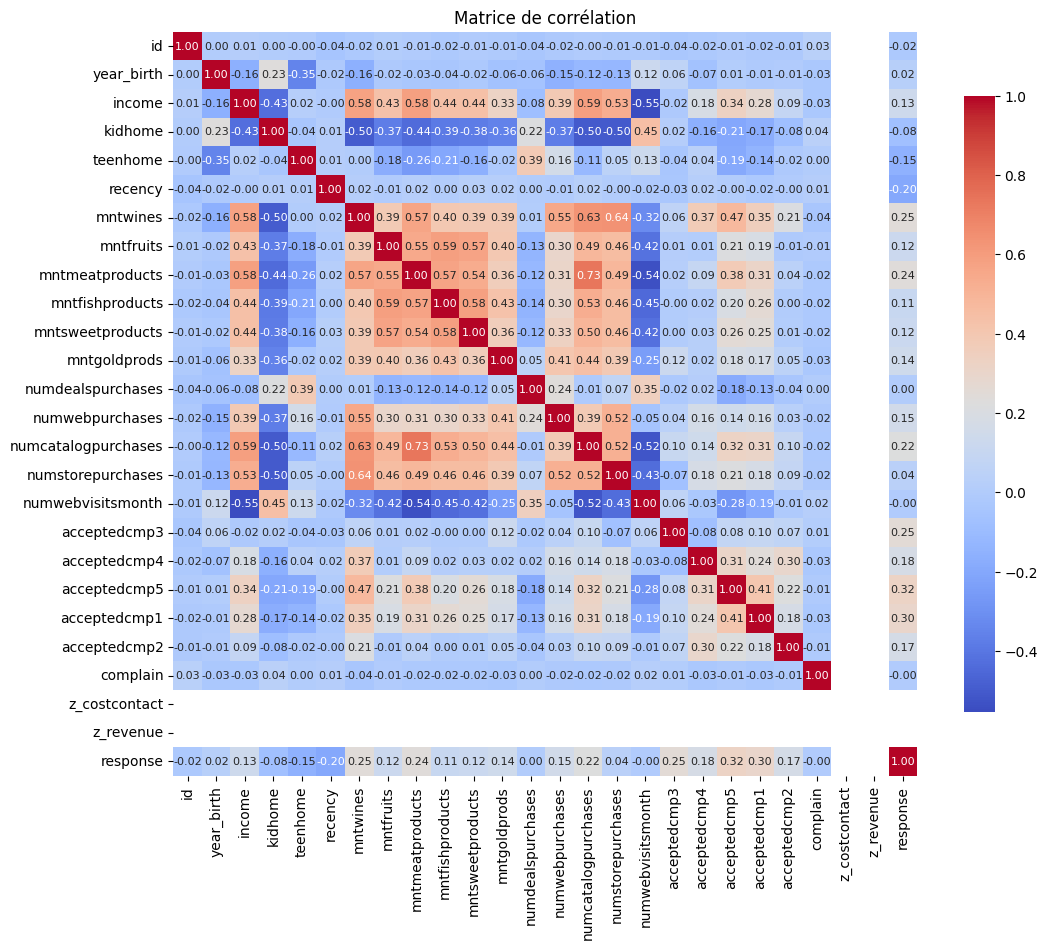

In [555]:
# Description générale du dataset
print("Description générale du dataset:")
print(f"Nombre total d'observations : {df.shape[0]}")
print(f"Nombre total de variables : {df.shape[1]}")
print(f"Types de données : \n{df.dtypes}")

# Liste des variables
print("\nListe des variables:")
print(df.columns.tolist())

# Statistiques descriptives pour les variables numériques
print("\nStatistiques descriptives pour les variables numériques:")
print(df.describe())

# Statistiques descriptives pour les variables catégorielles
print("\nStatistiques descriptives pour les variables catégorielles:")
print(df.describe(include=['object', 'category']))

# Valeurs manquantes
print("\nValeurs manquantes dans le dataset:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Valeurs aberrantes - par exemple pour les variables numériques
print("\nValeurs aberrantes (5 premières lignes) :")
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    print(f"\nValeurs aberrantes pour {column}:")
    print(df[column][df[column] > df[column].mean() + 2.8 * df[column].std()])  # Z-score > 3

# matrice de corrélation

plt.figure(figsize=(12, 10))
correlation_matrix = df.drop(columns=['marital_status', 'education', 'dt_customer']).dropna().corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={'size' : 8})
plt.title('Matrice de corrélation')
plt.show()


In [556]:
# Suppression des variables sans variance
df = df.drop(columns=['z_revenue', 'z_costcontact'])

Remplacer les valeurs empoisonées + simplification valeurs

In [557]:
df['marital_status'] = df['marital_status'].apply(lambda x: "Married" if (x == "YOLO" or x == "Absurd" or x == "Together") else x)
df['marital_status'] = df['marital_status'].apply(lambda x: "Single" if (x == "Divorced" or x == "Widow" or x == "Alone") else x)

In [558]:
def tri_education(education):
    if education == 'Basic' or education == '2n Cycle':
        return "Undergrad"
    elif education == 'Graduation':
        return "Grad"
    else:
        return "Postgrad"

df['education'] = df['education'].apply(tri_education)

Nouvelles variables

In [559]:
df.rename(columns={'marital_status': 'live_alone'}, inplace=True)

In [560]:
df.rename(columns={'year_birth': 'age'}, inplace=True)
df['age'] = 2024 - df['age']

In [561]:
df['n_children'] = df['kidhome'] + df['teenhome']
for cel in df['live_alone']:
    if cel == 1 :
        df['n_familly'] = df['n_children'] + 1
    else :
        df['n_familly'] = df['n_children'] + 2

df = df.drop(columns= ['kidhome', 'teenhome'])

In [562]:
df['n_accepted_offer'] = df['acceptedcmp1'] + df['acceptedcmp2'] + df['acceptedcmp3'] + df['acceptedcmp4'] + df['acceptedcmp5'] 
df = df.drop(columns=['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5'])

In [563]:
def tri_n_accepted_offer(n_accepted_offer):
    if n_accepted_offer == 4:
        return 3
    else :
        return n_accepted_offer

df['n_accepted_offer'] = df['n_accepted_offer'].apply(tri_n_accepted_offer)
df['n_accepted_offer'].value_counts()

n_accepted_offer
0    1777
1     325
2      83
3      55
Name: count, dtype: int64

In [564]:
df.rename(columns={'dt_customer': 'day_since_1st_order'}, inplace=True)
df['day_since_1st_order'] = (pd.to_datetime('today') - pd.to_datetime(df['day_since_1st_order'])).dt.days

In [565]:
df['spent'] = df['mntmeatproducts'] + df['mntfishproducts'] + df['mntsweetproducts'] + df['mntgoldprods']

In [566]:
df['is_parent'] = [1 if cel > 0 else 0 for cel in df['n_children']]

In [567]:
col_bin = df[['live_alone', 'complain', 'response', 'is_parent']]

Encoder variable catégorielle

In [568]:
df['live_alone'].value_counts()

live_alone
Married    1448
Single      792
Name: count, dtype: int64

In [569]:
label_encoder = LabelEncoder()
label_encoder.fit(df['live_alone'])
df["live_alone"] = label_encoder.transform(df['live_alone'])

In [570]:
ordinal_encoder = OrdinalEncoder(categories=[['Undergrad', 'Grad', 'Postgrad']]) 
df['education'] = ordinal_encoder.fit_transform(df[['education']])

In [571]:
df.head()

,id,age,education,live_alone,income,day_since_1st_order,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,complain,response,n_children,n_familly,n_accepted_offer,spent,is_parent
0,5524,67,1.0,1,58138.0,4425,58,635,88,546,172,88,88,3,8,10,4,7,0,1,0,2,0,894,0
1,2174,70,1.0,1,46344.0,3875,38,11,1,6,2,1,6,2,1,1,2,5,0,0,2,4,0,15,1
2,4141,59,1.0,0,71613.0,4074,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,2,0,301,0
3,6182,40,1.0,0,26646.0,3901,26,11,4,20,10,3,5,2,2,0,4,6,0,0,1,3,0,38,1
4,5324,43,2.0,0,58293.0,3923,94,173,43,118,46,27,15,5,5,3,6,5,0,0,1,3,0,206,1


Supr les valeurs aberrantes

In [572]:
aberrant_col = df[['age', 'income', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases']].columns
 

In [573]:
for column in aberrant_col:

    mask = df[column] > df[column].mean() + 2.8 * df[column].std()
    df.loc[mask, column] = np.nan

df.isnull().sum().sum()

np.int64(493)

Remplacer NaN aberrant KNN Imputer

In [574]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled = scaler.fit_transform(df_scaled)

In [575]:
imputer = KNNImputer(n_neighbors=3, weights='distance')
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)

In [576]:
new_order = [
    'id', 'education', 'age', 'income', 'n_children', 'n_familly', 'is_parent', 
    'live_alone', 'day_since_1st_order', 'recency', 'mntwines', 'mntfruits', 
    'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 
    'spent', 'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 
    'numstorepurchases', 'numwebvisitsmonth', 'n_accepted_offer', 'complain', 'response'
]

# Réordonner les colonnes du DataFrame
df_imputed = df_imputed[new_order]

for column in aberrant_col:

    mask = df_imputed[column] > df_imputed[column].mean() + 2.8 * df_imputed[column].std()
    df_imputed.loc[mask, column] = np.nan

df_imputed.isnull().sum().sum()

np.int64(386)

In [577]:
for column in aberrant_col:
    
    median = df_imputed[column].median()

    df_imputed[column] = median

In [578]:
for column in aberrant_col:

    mask = df_imputed[column] > df_imputed[column].mean() + 2.8 * df_imputed[column].std()
    df_imputed.loc[mask, column] = np.nan

df_imputed.isnull().sum().sum()

np.int64(0)

In [ ]:
# Matrice de corrélation pour voir si variance différente

new_order = [
    'id', 'education', 'age', 'income', 'n_children', 'n_familly', 'is_parent', 
    'live_alone', 'day_since_1st_order', 'recency', 'mntwines', 'mntfruits', 
    'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 
    'spent', 'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 
    'numstorepurchases', 'numwebvisitsmonth', 'n_accepted_', 'complain', 'response'
]

# Réordonner les colonnes du DataFrame
df_imputed = df_imputed[new_order]

plt.figure(figsize=(12, 10))
correlation_matrix_imputed = df_imputed.corr()
sns.heatmap(correlation_matrix_imputed, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={'size' : 8})
plt.title('Matrice de corrélation')
plt.show()


In [ ]:
# Distribution des valeurs
cols = df_imputed.columns

# Définir le nombre de lignes et de colonnes pour les subplots
n_cols = 3
n_rows = len(cols) // n_cols + (len(cols) % n_cols > 0)  # Arrondi vers le haut si besoin
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))

# Aplatir les axes pour faciliter l'itération
axes = axes.flatten()

# Boucle à travers les colonnes pour créer des histogrammes
for i, col in enumerate(cols):
    sns.histplot(df_imputed[col], bins=30, kde=True, ax=axes[i])  # Utiliser l'axe spécifique
    axes[i].set_title(f'Histogramme de {str(col)}')
    axes[i].set_xlabel('Valeurs')
    axes[i].set_ylabel('Fréquence')
    axes[i].grid(axis='y')

# Supprimer les axes inutilisés (s'ils existent)
if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
plt.show()

In [ ]:
# Supposons que df_imputed est déjà défini et que tu as les colonnes que tu veux analyser
cols = df_imputed.columns

# Définir le nombre de lignes et de colonnes pour les subplots
n_cols = 3
n_rows = len(cols) // n_cols + (len(cols) % n_cols > 0)  # Arrondi vers le haut si besoin
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))

# Aplatir les axes pour faciliter l'itération
axes = axes.flatten()

# Boucle à travers les colonnes pour créer des Q-Q plots
for i, col in enumerate(cols):
    data = df_imputed[col].dropna()  # Supprimer les NaN
    if len(data) > 1:  # Vérifier que la longueur est suffisante
        stats.probplot(data, dist="norm", plot=axes[i])  # Utiliser l'axe spécifique
        axes[i].set_title(f'Q-Q Plot de {str(col)}')
    else:
        axes[i].set_title(f'Pas assez de données pour {str(col)}')  # Titre pour les colonnes insuffisantes
    axes[i].grid(axis='y')

# Supprimer les axes inutilisés (s'ils existent)
if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
plt.show()

In [ ]:
### Générer boxplot pour valeurs aberrantes

cols = df_imputed.columns

fig, axes = plt.subplots(nrows=len(cols)//3 + 1, ncols=3, figsize=(12, 15))  # 3 colonnes, lignes dynamiques

axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].boxplot(df_imputed[col])
    axes[i].set_title(f'Boxplot {str(col)}')
    axes[i].set_ylabel(str(col))
    axes[i].grid(axis='y')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
print("\nValeurs aberrantes (5 premières lignes) :")
for column in df_imputed.select_dtypes(include=['float64', 'int64']).columns:
    print(f"\nValeurs aberrantes pour {column}:")
    print(df_imputed[column][df_imputed[column] > df_imputed[column].mean() + 2.8 * df_imputed[column].std()])  # Z-score > 3

In [ ]:
for column in aberrant_col:

    mask = df_imputed[column] > df_imputed[column].mean() + 2.8 * df_imputed[column].std()
    df_imputed.loc[mask, column] = np.nan

df_imputed.isnull().sum()

Distribution des classes

In [ ]:
# Distrib classe offre accepté

plt.figure(figsize=(8, 5))
sns.countplot(x='response', data=df)
plt.title('Distribution des classes (dernière offre accepté ou non)')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.xticks(ticks=[0, 1], labels=['Non (0)', 'Oui (1)'])
plt.show()

In [ ]:
# Distrib classe seul ou en couple

plt.figure(figsize=(8, 5))
sns.countplot(x='live_alone', data=df)
plt.title('Vie seul')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.xticks(ticks=[0, 1], labels=['Non (0)', 'Oui (1)'])
plt.show()

Création des df segmentés

In [ ]:
df_seg_purchase = df.drop_duplicates()
df = df.drop(columns=['mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods'])
df_seg_purchase.drop(columns=['spent'])

Standardisation

PCA

Clustering